# Adversarial Search: Playing Connect 4

Student Name: Jadon Swearingen

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: JS

## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Initial state: Blank 6row by 7 column grid
Actions: Place  colored disk(red or yellow) in one of the columns {1-7}, where it falls to the bottom of the column. If the column is full, you cannot choose that action anymore

Transition model:
Takes a state(board), and given an action, returns the new board. For example, if the state was an empty grid and you drop a red disk in column 2, the result function returns the new state where there is only one piece on the board (bottom row of column 2).

Goal State: 4 in a row of your color (diagonal, horizontal, or vertical) is utility 1. 4 in a row of other color is -1 utility. completely filled board with no 4 in a row is utility 0.

How big is the state space? Give an estimate and explain it.

Each spot has 3 options: red, yellow, empty. There are 42 spots. This makes the state space 3^42 = 1.1 * 10^20, since each spot adds another three possibilities that are multiplied together. However, many of these are unreachable due to having to alternate when placing, and so each option can only happen a max of 21 times. This means that things like all red are not reachable. Due to this, Wikipedia gives an exact number of only 4,531,985,219,092.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The branching factor is 7, since there are 7 legal moves. The depth is 42, since after 42 moves the game has to be done. Worst case, that means 7^42, which is more than 3 * 10^37. However, as it reaches goal states, it will be reduced.

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [534]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the form: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

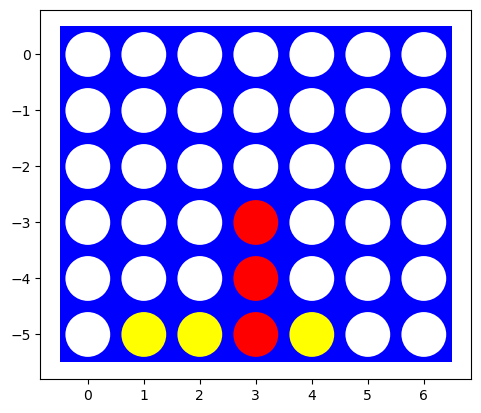

In [535]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(s)`.
* The transition model `result(s, a)`.
* Check for terminal states `terminal(s)`.
* The utility function `utility(s)`.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [536]:
import math
import copy
# Your code/ answer goes here.
# def actions(board):
#     #returns a list of 1-7 matched to the row # which are available actions
#     available = []
#     for i in range(len(board[0])):
#         if board[0][i] == 0:
#             available.append(i+1)
#     return available
class BaseConnectFour:
    @staticmethod
    def actions(board):
        #returns a list of 0-6 matched to the row # which are available actions
        available = []
        for i in range(len(board[0])):
            if board[0][i] == 0:
                available.append(i)
        return available


    @staticmethod
    def result(board,action,player):
        new_board = copy.deepcopy(board)
        color = player
        action = abs(action)
        # if action >= len(new_board[0]) or new_board[0][action] != 0:
        #     raise ValueError("Invalid action")
        if action >= len(new_board[0]):
            raise ValueError("Invalid action: Action is outside the board's boundaries")

        if new_board[0][action] != 0:
            raise ValueError("Invalid action: Column is full")
        row = -1
        for i in reversed(range(len(new_board))):
            if new_board[i][action] == 0:
                new_board[i][action] = color
                row = i
                break
        #return the new_board, and (row placed, column placed)
        return (new_board,(row,action))

    #a faster implementation would involve knowing the last action, and then only checking directions from there
    #checks if the board is an end state, i.e. someone has won by either 4 in a row horizontal
    #, vertical, diagonal, or the board is filled up.
    @staticmethod
    def terminal(b):
        board = copy.deepcopy(b)
        # check the if the board is filled up
        for col in range(len(board[0])):
            if board[0][col] == 0:
                break
        else:
            return True
        
        #check for rows
        for row in board:
            for i in range(len(row)-3):
                if abs(sum(row[i:i+4])) == 4:
                    return True
        
        #check for columns
        for col in range(len(board[0])):
            for i in range(len(board) - 3):
                if abs(sum(board[i][col] for i in range(i, i+4))) == 4:
                    return True
        
        # Check right diagonals
        for row in range(len(board) - 3):
            for col in range(len(board[0]) - 3):
                if abs(sum(board[row+i][col+i] for i in range(4))) == 4:
                    return True

        # Check left diagonals
        for row in range(3, len(board)):
            for col in range(len(board[0]) - 3):
                if abs(sum(board[row-i][col+i] for i in range(4))) == 4:
                    return True
                
                
        #if none of these, return false
        return False


    #fast version of terminal using last_action, where last_action is the row,col of the last placed piece.
    @staticmethod
    def terminalFast(board, last_action):
        color = board[last_action[0]][last_action[1]]
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for dx, dy in directions:
            count = 0
            for dir in [-1, 1]:
                for dist in range(1, 4):
                    x, y = last_action[0] + dir*dist*dx, last_action[1] + dir*dist*dy
                    if (0 <= x < len(board)) and (0 <= y < len(board[0])) and (board[x][y] == color):
                        count += 1
                    else:
                        break
            if count >= 3:
                return True

        # Check if the board is filled up
        for col in range(len(board[0])):
            if board[0][col] == 0:
                break
        else:
            return True

        return False

    @staticmethod
    def utility(b,player=1):
        board = copy.deepcopy(b)
        # check the if the board is filled up
        
        #check for rows
        for row in board:
            for col in range(len(row)-3):
                if abs(sum(row[col:col+4])) == 4:
                    return row[col] * player
        
        #check for columns
        for col in range(len(board[0])):
            for row in range(len(board) - 3):
                if abs(sum(board[i][col] for i in range(row, row+4))) == 4:
                    return board[row][col]* player
        
        # Check right diagonals
        for row in range(len(board) - 3):
            for col in range(len(board[0]) - 3):
                if abs(sum(board[row+i][col+i] for i in range(4))) == 4:
                    return board[row][col]* player

        # Check left diagonals
        for row in range(3, len(board)):
            for col in range(len(board[0]) - 3):
                if abs(sum(board[row-i][col+i] for i in range(4))) == 4:
                    return board[row][col]* player
                
        for col in range(len(board[0])):
            if board[0][col] == 0:
                break
        else:
            return 0
        #if none of these, return false
        return None
        
    @staticmethod
    def utilityFast(board, last_action,player=1):
        color = board[last_action[0]][last_action[1]]
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]

        for dx, dy in directions:
            count = 0
            for dir in [-1, 1]:
                for dist in range(1, 4):
                    x, y = last_action[0] + dir*dist*dx, last_action[1] + dir*dist*dy
                    if (0 <= x < len(board)) and (0 <= y < len(board[0])) and (board[x][y] == color):
                        count += 1
                    else:
                        break
            if count >= 3:
                return board[last_action[0]][last_action[1]]* player

        # Check if the board is filled up
        for col in range(len(board[0])):
            if board[0][col] == 0:
                break
        else:
            return 0

        return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 or -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [537]:
# Your code/ answer goes here.
class RandomPlayer(BaseConnectFour):
    def __init__(self,name="random"):
        self.__name__ = name
    def act(self,board, player=1):
        return np.random.choice(BaseConnectFour.actions(board))
        # return np.random.choice(actions(board)) * player

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [538]:
DEBUG = 0
import time
import numpy as np
import matplotlib.pyplot as plt

def play(redAgent, yellowAgent, N=100,boardShape=(6,7),graph=False,b = None):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {-1: 0, 1: 0, 0: 0}
    times = {redAgent.__class__.__name__: [], yellowAgent.__class__.__name__: []}  # Record times for each class
    if b == None:
        b = empty_board(shape=boardShape)
    for i in range(N):
        board = b
        player = 1

        while True:


            start_time = time.time()
            if player == 1:
                c=redAgent
                playerAction = redAgent.act(board, player)
            else:
                c=yellowAgent
                playerAction = yellowAgent.act(board, player)

            end_time = time.time()
            times[c.__class__.__name__].append(end_time - start_time)  # Record time taken

            board, exactAction = BaseConnectFour.result(board, playerAction, player)
            if(DEBUG):
                visualize(board)
            res = BaseConnectFour.utilityFast(board, exactAction)
            if res is not None:
                results[res] += 1
                break
            player = -player
    if graph:
        # Convert lists of times to numpy arrays
        for class_name in times:
            times[class_name] = np.array(times[class_name])

        # Plot the times
        plt.figure(figsize=(10,6))
        for class_name, time_array in times.items():
            plt.plot(time_array, label=class_name)
        plt.xlabel('Move number')
        plt.ylabel('Time taken (s)')
        plt.legend()
        plt.show()

    return results, times


In [539]:
results, _ = play(RandomPlayer("red"),RandomPlayer("yellow"),1000)
print(results)

{-1: 427, 1: 569, 0: 4}


You will notice that whichever player starts will win more often when playing randomly. It is also very rare for a tie to occur, happening less than 5 times per thousand

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [540]:

# Your code/ answer goes here.
DEBUG = 0
COUNT = 0

class JadonMinMaxSearch(BaseConnectFour):
    def __init__(self, name = "An Agent", max_depth = 4):
        self.name = name
        self.max_depth = max_depth
    # def act(board, player=1):
    
    # def minimax_search(board, player = 'x'):
    def act(self,board,player=1):
        """start the search."""
        global DEBUG, COUNT
        COUNT = 0
        
        value, move = self.max_value(board, player,0)
        
        if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
        return move
        # return { "move": move, "value": value}

    def max_value(self,state, player,depth):
        """player's best move."""
        global DEBUG, COUNT
        COUNT += 1
        
        # return utility of state if it is a terminal state
        v = BaseConnectFour.utility(state, player)
        if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
        if v is not None: return v, None
        if depth==self.max_depth: return 0,None
            
        v, move = -math.inf, None

        # check all possible actions in the state, return move with the largest value
        for a in BaseConnectFour.actions(state):
            # v2, a2 = min_value(result(state, player, a), player)

            v2, a2 = self.min_value(BaseConnectFour.result(state, a,player)[0], player,depth+1)
            if v2 > v:
                v, move = v2, a
        
        if DEBUG >= 2: print("max out: " + str(state) + str([v, move]) ) 
        return v, move

    def min_value(self,state, player,depth):
        """opponent's best response."""
        global DEBUG, COUNT
        COUNT += 1
        
        # return utility of state if it is a terminal state
        v = BaseConnectFour.utility(state, player)
        if DEBUG >= 2: print("min in: " + str(state) + str([v]) ) 
        if v is not None: return v, None
        if depth==self.max_depth: return 0,None

        
        v, move = +math.inf, None

        # check all possible actions in the state, return move with the smallest value
        for a in BaseConnectFour.actions(state):
            # v2, a2 = max_value(result(state, other(player), a), player)

            v2, a2 = self.max_value(BaseConnectFour.result(state, a,-player)[0], player,depth+1)
            if v2 < v:
                v, move = v2, a
        
        if DEBUG >= 2: print("min out: " + str(state) + str([v, move]) ) 
        return v, move

In [541]:
results, times = play(JadonMinMaxSearch("red",4),RandomPlayer("red"),100,(4,4))
print(results)

{-1: 2, 1: 75, 0: 23}


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [542]:
# Your code/ answer goes here.
agent = JadonMinMaxSearch(max_depth=4)

# Winning opportunity for the agent on the next move
board1 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0]
]

# Test Case 2: Winning opportunity for the agent in the second column
board2 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0, 0],
    [-1, 1, 0, 0, 0, 0, 0],
    [1, -1, 1, 0, 0, 0, 0],
    [-1, 1, -1, 0, 0, 0, 0]
]

# Test Case 3: Winning opportunity for the agent in the third column
board3 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0]
]

# Test Case 4: Winning opportunity for the agent in the fourth column
board4 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0]
]

# Test Case 5: Winning opportunity for the agent in the fifth column
board5 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0]
]
boards = [board1,board2,board3,board4,board5]

print("should be 0", agent.act(board1, 1))  
print("should be 3", agent.act(board2, 1))  
print("should be 1 or 5 or 0 (since 0 leads to a state where it wins no matter what also)", agent.act(board3, 1))  
print("should be 3", agent.act(board4, 1))  
print("should be 3", agent.act(board5, 1))  


should be 0 0
should be 3 3
should be 1 or 5 or 0 (since 0 leads to a state where it wins no matter what also) 0
should be 3 3
should be 3 3


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [543]:
import pandas as pd
agent = JadonMinMaxSearch("Better",4)
results = []
for size in range(4, 8):
    board = np.zeros((6, size))
    start_time = time.time()
    agent.act(board, 1)
    end_time = time.time()
    results.append([size, end_time - start_time])

df = pd.DataFrame(results, columns=['Board Size', 'Time'])
print(df)

   Board Size      Time
0           4  0.183226
1           5  0.487804
2           6  1.278039
3           7  2.895605


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [544]:
# Your code/ answer goes here.
class JadonBetterActionsMinMaxSearch(JadonMinMaxSearch):
    @staticmethod
    def actions(board):
        """Return a list of actions that are valid from this board."""
        num_cols = len(board[0])
        center_first = sorted(range(num_cols), key=lambda x: abs(x - num_cols // 2))
        valid_actions = []
        for col in center_first:
            if board[0][col] == 0:  # If the top cell in a column is empty
                valid_actions.append(col)
        return valid_actions

In [548]:
import pandas as pd
agent = JadonBetterActionsMinMaxSearch("Better",4)
results = []
for size in range(4, 8):
    board = np.zeros((6, size))
    start_time = time.time()
    agent.act(board, 1)
    end_time = time.time()
    results.append([size, end_time - start_time])

df = pd.DataFrame(results, columns=['Board Size', 'Time'])
print(df)

   Board Size      Time
0           4  0.234592
1           5  0.497962
2           6  1.448474
3           7  2.800962


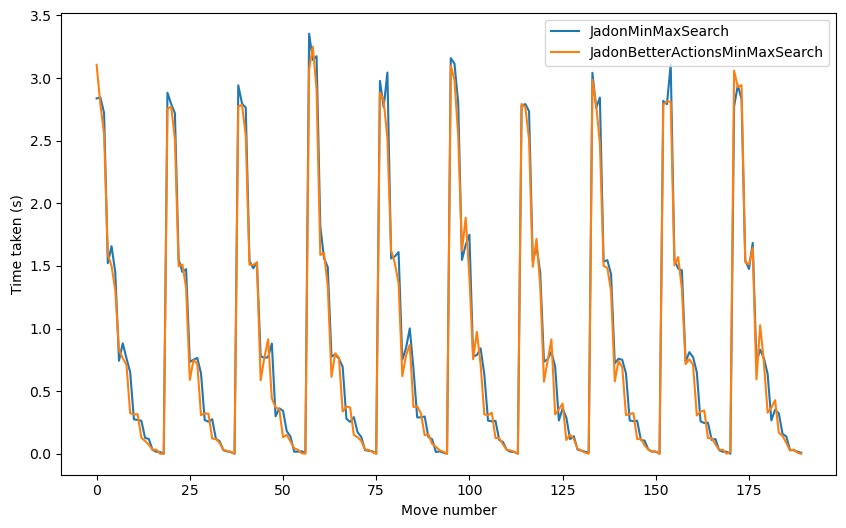

|   Result |   Count |
|---------:|--------:|
|       -1 |      10 |
|        1 |       0 |
|        0 |       0 |
| Class                          |   Average Time |
|:-------------------------------|---------------:|
| JadonMinMaxSearch              |       0.924089 |
| JadonBetterActionsMinMaxSearch |       0.875358 |


In [549]:
results, times = play(JadonMinMaxSearch("red",4),JadonBetterActionsMinMaxSearch("yellow",4),10,graph=True)

from tabulate import tabulate

# Print results
print(tabulate([(k, v) for k, v in results.items()], headers=['Result', 'Count'], tablefmt='pipe'))

# Print average times
avg_times = {k: np.mean(v) for k, v in times.items()}
print(tabulate([(k, v) for k, v in avg_times.items()], headers=['Class', 'Average Time'], tablefmt='pipe'))

You will notice that the middle first move ordering strategy, rather than the left to right, makes a difference in both move time as well as win percentage. Now, for the same depth, the middle move ordering always wins, and the average time to move is about 1% lower, (which isn't that much, but it's because at the end it finds winning moves faster).

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

You can limit the depth to a depth that allows it to complete moves in a reasonable amount of time. When increasing the board size, this is necessary because we do not have the computing power to check every single outcome of every move due to the large state space size.

Already implemented a max depth, so that it runs in a reasonable amount of time.

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [550]:
# Your code/ answer goes here.
results, times = play(JadonBetterActionsMinMaxSearch("red",max_depth=4),RandomPlayer("yellow"),100,(4,4))

from tabulate import tabulate

print("Results for depth of 4:")
# Print results
print(tabulate([(k, v) for k, v in results.items()], headers=['Result', 'Count'], tablefmt='pipe'))

# Print average times
avg_times = {k: np.mean(v) for k, v in times.items()}
print(tabulate([(k, v) for k, v in avg_times.items()], headers=['Class', 'Average Time'], tablefmt='pipe'))




results, times = play(JadonBetterActionsMinMaxSearch("red",max_depth=5),RandomPlayer("yellow"),100,(4,4))

from tabulate import tabulate

print("results for depth of 5:")
# Print results
print(tabulate([(k, v) for k, v in results.items()], headers=['Result', 'Count'], tablefmt='pipe'))

# Print average times
avg_times = {k: np.mean(v) for k, v in times.items()}
print(tabulate([(k, v) for k, v in avg_times.items()], headers=['Class', 'Average Time'], tablefmt='pipe'))



print("results for depth of 6:")
results, times = play(JadonBetterActionsMinMaxSearch("red",max_depth=6),RandomPlayer("yellow"),100,(4,4))

from tabulate import tabulate

# Print results
print(tabulate([(k, v) for k, v in results.items()], headers=['Result', 'Count'], tablefmt='pipe'))

# Print average times
avg_times = {k: np.mean(v) for k, v in times.items()}
print(tabulate([(k, v) for k, v in avg_times.items()], headers=['Class', 'Average Time'], tablefmt='pipe'))

Results for depth of 4:
|   Result |   Count |
|---------:|--------:|
|       -1 |       0 |
|        1 |      65 |
|        0 |      35 |
| Class                          |   Average Time |
|:-------------------------------|---------------:|
| JadonBetterActionsMinMaxSearch |    0.0301973   |
| RandomPlayer                   |    4.80226e-05 |
results for depth of 5:
|   Result |   Count |
|---------:|--------:|
|       -1 |       1 |
|        1 |      76 |
|        0 |      23 |
| Class                          |   Average Time |
|:-------------------------------|---------------:|
| JadonBetterActionsMinMaxSearch |    0.114061    |
| RandomPlayer                   |    0.000112411 |
results for depth of 6:
|   Result |   Count |
|---------:|--------:|
|       -1 |       1 |
|        1 |      83 |
|        0 |      16 |
| Class                          |   Average Time |
|:-------------------------------|---------------:|
| JadonBetterActionsMinMaxSearch |    0.59563     |
| RandomPla

Because the board size is so small, the random player can sometimes make the right moves in a row to beat or tie our basic min-max search. As we increase its depth, it wins more often, but it also takes longer.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

In [551]:
# Your code/ answer goes here.
from overrides import overrides
class JadonBetterHeuristicsBetterActionsMinMaxSearch(JadonBetterActionsMinMaxSearch):
    @overrides
    def max_value(self,state, player,depth):
        """player's best move."""
        global DEBUG, COUNT
        COUNT += 1
        
        # return utility of state if it is a terminal state
        v = BaseConnectFour.utility(state, player)
        if DEBUG >= 2: print("max in: " + str(state) + str([v]) ) 
        if v is not None: return v * 1000, None
        if depth==self.max_depth: return self.heuristic(state, player),None
            
        v, move = -math.inf, None

        # check all possible actions in the state, return move with the largest value
        for a in BaseConnectFour.actions(state):
            # v2, a2 = min_value(result(state, player, a), player)

            v2, a2 = self.min_value(BaseConnectFour.result(state, a,player)[0], player,depth+1)
            if v2 > v:
                v, move = v2, a
        
        if DEBUG >= 2: print("max out: " + str(state) + str([v, move]) ) 
        return v, move
    @overrides
    def min_value(self,state, player,depth):
        """opponent's best response."""
        global DEBUG, COUNT
        COUNT += 1
        
        # return utility of state if it is a terminal state
        v = BaseConnectFour.utility(state, player)
        if DEBUG >= 2: print("min in: " + str(state) + str([v]) ) 
        if v is not None: return v*1000, None
        if depth==self.max_depth: return self.heuristic(state, player),None

        
        v, move = +math.inf, None

        # check all possible actions in the state, return move with the smallest value
        for a in BaseConnectFour.actions(state):
            # v2, a2 = max_value(result(state, other(player), a), player)

            v2, a2 = self.max_value(BaseConnectFour.result(state, a,-player)[0], player,depth+1)
            if v2 < v:
                v, move = v2, a
        
        if DEBUG >= 2: print("min out: " + str(state) + str([v, move]) ) 
        return v, move
    
    
    def heuristic(self,state, player):
        #after thinking of some ways to do a heuristic (like just counting all the triples)
        # I looked up a good heuristic online which includes the center column and doubles and singles
        #this makes it a very good heuristic.
        """
        Heuristic evaluation function for Connect 4 board state.
        :param board: 2D list representing the Connect 4 board.
        :param player: The player to evaluate the board state for.
        :return: A score representing the 'goodness' of the board state for the player.
        """
        board = np.array(state)
        score = 0

        # Score center column
        center_array = [int(i) for i in list(board[:, 2])]
        center_count = center_array.count(player)
        score += center_count * 3

        # Score Horizontal locations
        for r in range(len(board)):
            row_array = [int(i) for i in list(board[r, :])]
            for c in range(4):
                window = row_array[c:c+4]
                score += self.evaluate_window(window, player)

        # Score Vertical locations
        for c in range(len(board[0])):
            col_array = [int(i) for i in list(board[:, c])]
            for r in range(3):
                window = col_array[r:r+4]
                score += self.evaluate_window(window, player)

        # Score posiive sloped diagonal
        for r in range(len(board)-3):
            for c in range(len(board[0])-3):
                window = [board[r+i][c+i] for i in range(4)]
                score += self.evaluate_window(window, player)

        # Score negative sloped diagonal
        for r in range(3, len(board)):
            for c in range(len(board[0])-3):
                window = [board[r-i][c+i] for i in range(4)]
                score += self.evaluate_window(window, player)

        return score

    def evaluate_window(self,window, player):
        """
        Evaluates a window of four cells and returns a score.
        :param window: List of four cells.
        :param player: The player to evaluate the window for.
        :return: Score for the window.
        """
        score = 0
        opp_player = player % 2 + 1
        if window.count(player) == 4:
            score += 100
        elif window.count(player) == 3 and window.count(0) == 1:
            score += 5
        elif window.count(player) == 2 and window.count(0) == 2:
            score += 2

        if window.count(opp_player) == 3 and window.count(0) == 1:
            score -= 4

        return score


### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [552]:
# Your code/ answer goes here.
DEBUG = 0
times_list = []
for depth in range(2, 5):  # Change the range as needed
    for board_size in [(5, 6), (6, 7), (7, 8)]:  # Add more board sizes as needed
        start = time.time()
        results, times = play(JadonBetterHeuristicsBetterActionsMinMaxSearch("red", depth),
                              JadonBetterHeuristicsBetterActionsMinMaxSearch("yellow", depth-1),
                              1,
                              board_size)
        end = time.time()
        time_taken = end - start
        times_list.append(time_taken) 
        print(f"Red(1) Depth: {depth}, Yellow(-1) Depth: {depth-1}  Board size: {board_size}, Results: {results}")
print(times_list)

Red(1) Depth: 2, Yellow(-1) Depth: 1  Board size: (5, 6), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 2, Yellow(-1) Depth: 1  Board size: (6, 7), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 2, Yellow(-1) Depth: 1  Board size: (7, 8), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 3, Yellow(-1) Depth: 2  Board size: (5, 6), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 3, Yellow(-1) Depth: 2  Board size: (6, 7), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 3, Yellow(-1) Depth: 2  Board size: (7, 8), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 4, Yellow(-1) Depth: 3  Board size: (5, 6), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 4, Yellow(-1) Depth: 3  Board size: (6, 7), Results: {-1: 0, 1: 1, 0: 0}
Red(1) Depth: 4, Yellow(-1) Depth: 3  Board size: (7, 8), Results: {-1: 0, 1: 1, 0: 0}
[0.915947675704956, 1.6274104118347168, 4.631514310836792, 3.8596153259277344, 4.754920959472656, 9.635130405426025, 8.33833622932434, 25.976656198501587, 152.25108981132507]


Through changing the of board size and depth, you will notice that the agent with the higher depth always wins.

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [553]:
# Your code/ answer goes here.
agent = JadonBetterHeuristicsBetterActionsMinMaxSearch("red",4)
print("should be 0", agent.act(board1, 1))  
print("should be 3", agent.act(board2, 1))  
print("should be 1 or 5 or 0 (since 0 leads to a state where it wins no matter what also)", agent.act(board3, 1))  
print("should be 3", agent.act(board4, 1))  
print("should be 3", agent.act(board5, 1))  

should be 0 0
should be 3 3
should be 1 or 5 or 0 (since 0 leads to a state where it wins no matter what also) 0
should be 3 3
should be 3 3


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [554]:
# Your code/ answer goes here.
# Your code/ answer goes here.
# DEBUG = 0
# results,times = play(JadonBetterHeuristicsBetterActionsMinMaxSearch("red",4),
#                      JadonBetterHeuristicsBetterActionsMinMaxSearch("yellow",4),
#                      1,
#                      (5,6))
# print(results)
DEBUG = 0
times_list = []

for depth in range(2, 6):  # Change the range as needed
    for board_size in [(5, 6), (6, 7), (7, 8)]:  # Add more board sizes as needed
        agent = JadonBetterHeuristicsBetterActionsMinMaxSearch("red",depth)
        start = time.time()
        choice = agent.act(empty_board(shape=board_size), 1)
        end = time.time()
        time_taken = end - start
        times_list.append(time_taken) 
        print(f"depth: {depth}, size: {board_size}, t = {time_taken}, C = {choice}")
print(times_list)

depth: 2, size: (5, 6), t = 0.042183637619018555, C = 2
depth: 2, size: (6, 7), t = 0.08543682098388672, C = 2
depth: 2, size: (7, 8), t = 0.1434650421142578, C = 2
depth: 3, size: (5, 6), t = 0.18743133544921875, C = 2
depth: 3, size: (6, 7), t = 0.5149500370025635, C = 2
depth: 3, size: (7, 8), t = 1.0977814197540283, C = 2
depth: 4, size: (5, 6), t = 1.1043283939361572, C = 2
depth: 4, size: (6, 7), t = 4.523494720458984, C = 2
depth: 4, size: (7, 8), t = 9.40776252746582, C = 2
depth: 5, size: (5, 6), t = 6.662064552307129, C = 2
depth: 5, size: (6, 7), t = 24.281134128570557, C = 2
depth: 5, size: (7, 8), t = 71.47818779945374, C = 2
[0.042183637619018555, 0.08543682098388672, 0.1434650421142578, 0.18743133544921875, 0.5149500370025635, 1.0977814197540283, 1.1043283939361572, 4.523494720458984, 9.40776252746582, 6.662064552307129, 24.281134128570557, 71.47818779945374]


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

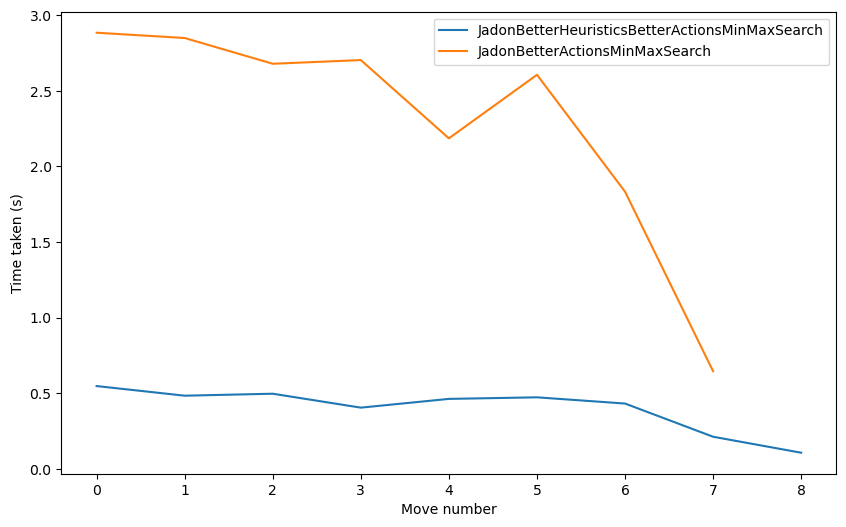

({-1: 0, 1: 1, 0: 0},
 {'JadonBetterHeuristicsBetterActionsMinMaxSearch': array([0.54807734, 0.48438597, 0.49744225, 0.40535855, 0.46327686,
         0.47357631, 0.43248391, 0.21291637, 0.1072998 ]),
  'JadonBetterActionsMinMaxSearch': array([2.88446426, 2.84950542, 2.6791923 , 2.70357037, 2.18601799,
         2.60625553, 1.83341002, 0.64608169])})

In [555]:
# Your code/ answer goes here.
agent1 = JadonBetterHeuristicsBetterActionsMinMaxSearch("red",3)
agent2 = JadonBetterActionsMinMaxSearch("yellow",4)
play(agent1,agent2,1,(6,7),True)

## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [556]:
# Your code/ answer goes here.
import random
import numpy as np

class JadonPureMonteCarloSearch(BaseConnectFour):
    def __init__(self, name="An Agent", num_simulations=1000):
        self.name = name
        self.num_simulations = num_simulations

    def act(self, board, player=1):
        counts = {move: 0 for move in self.actions(board)}
        wins = {move: 0 for move in self.actions(board)}

        for _ in range(self.num_simulations):
            move = random.choice(list(counts.keys()))
            counts[move] += 1
            wins[move] += self.simulate(board, move, player)

        win_rates = {move: wins[move] / counts[move] for move in counts}
        best_move = max(win_rates, key=win_rates.get)
        return best_move

    def simulate(self, board, move, playerOrig):
        player = playerOrig
        temp_board, _ = self.result(np.copy(board), move, player)  # Use the returned board
        while True:
            if self.terminal(temp_board):
                return self.utility(temp_board,playerOrig)
                # return 1 if self.utility(temp_board, player) > 0 else 0
            # elif not self.actions(temp_board):
            #     return 0.5
            else:
                temp_move = random.choice(self.actions(temp_board))
                player = -player
                temp_board, _ = self.result(temp_board, temp_move, player)  # Use the returned board

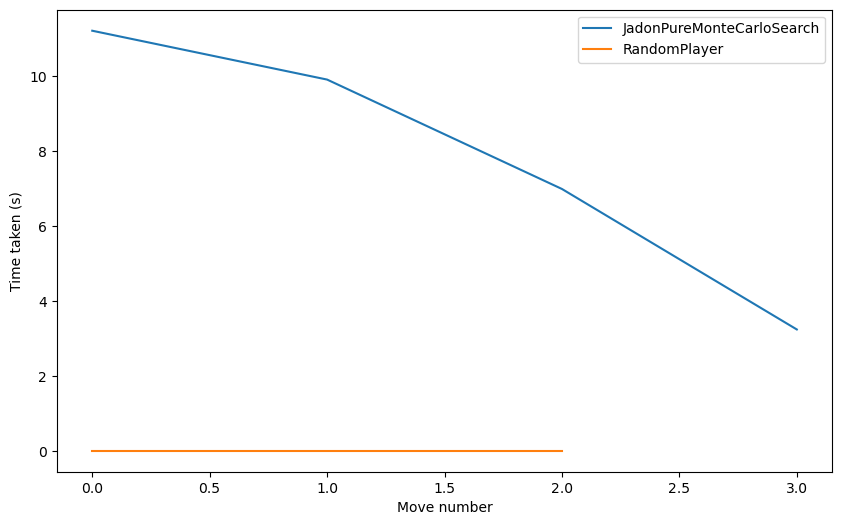

{-1: 0, 1: 1, 0: 0}


In [557]:
agent1 = JadonPureMonteCarloSearch("red",1000)
# agent2 = JadonBetterHeuristicsBetterActionsMinMaxSearch("yellow",3)
agent2 = RandomPlayer("yellow")
DEBUG = 0
results, times = play(agent1,agent2,1,(5,6),True)
print(results)


### Best First Move

Use Oure Monte Carlo Search to determine what the best first move is? Describe under what assumptions this is the "best" first move.  

In [558]:
# Your code/ answer goes here.
board6 = [
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, -1],
    [0, 0, 0, 0, 0, 0, -1],
    [1, 1, 1, 0, 0, 0, -1]
]
agent1 = JadonPureMonteCarloSearch("red",1000)
action = agent1.act(board6,1)
print(action)


3


In [559]:
agent1 = JadonPureMonteCarloSearch("red",1000)
action = agent1.act(empty_board(),1)
print(action)


3


Under the assumption that after the first move, all moves are random, the best place to put your first move is the middle column, which can be confirmed by looking it up online.